In [ ]:
#Provided by Hazeeq Zaini

In [1]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Download the fruit dataset by using the below code:
!gdown https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip 

Downloading...
From: https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip
To: /content/fruit_dataset_exercise.zip
100% 10.6M/10.6M [00:00<00:00, 108MB/s]


#Q1. Training the dataset using a basic model

In [4]:
#Unzip the dataset and make sure the path for it is correct
!unzip  fruit_dataset_exercise.zip -d /content/gdrive/MyDrive/fruit_dataset

Archive:  fruit_dataset_exercise.zip
replace /content/gdrive/MyDrive/fruit_dataset/train/durian/durian28.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/durian/durian28.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/durian/durian33.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/0024ef4511cb07be8ccd234b7143304d64899744.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/0066c2ae111450ba6a6ef03486657b58252e6e1f.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/01556c59f720c859217328371036cd6ec1d78732.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/065ae0e728e01e9aacd0c9bc7f37f826ba82fe89.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/083227f662dbc1739041e9e4e1775a049c51606f.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/092d44f61e6d704fc5245a06bc25b80af47b003a.jpg  
  inflating: /conten

In [5]:
#Remove the dataset
!rm -rf /content/fruit_dataset_exercise.zip

In [6]:
#Import necessary libaries
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [7]:
#Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees=15),
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [8]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'
dataset = '/content/gdrive/MyDrive/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 16

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [9]:
data['train']

Dataset ImageFolder
    Number of datapoints: 521
    Root location: /content/gdrive/MyDrive/fruit_dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
#######################################################
#                  Create Dataloader                  #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [12]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [13]:
#######################
# DEFINE YOUR OWN MODEL
#######################

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)


# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
from torchsummary import summary #PENTING
print(summary(model_ft,(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
# 4. Train the model for 30 epochs
 
num_epochs = 30
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 0.8977, Accuracy: 74.0883%, 
		Validation : Loss : 5.8243, Accuracy: 56.0372%, Time: 5.5124s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.4418, Accuracy: 85.0288%, 
		Validation : Loss : 0.9255, Accuracy: 79.8762%, Time: 4.5038s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.3764, Accuracy: 87.7159%, 
		Validation : Loss : 1.2953, Accuracy: 75.8514%, Time: 4.5882s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.3256, Accuracy: 89.6353%, 
		Validation : Loss : 0.8856, Accuracy: 79.8762%, Time: 4.5570s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.2551, Accuracy: 90.7869%, 
		Validation : Loss : 0.8974, Accuracy: 79.2570%, Time: 4.5861s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.2409, Accuracy: 91.3628%, 
		Validation : Loss : 0.6812, Accuracy: 82.3529%, Time: 4.5934s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.2169, Accuracy: 90.5950%, 
		Validation : Loss : 0.4952, Accuracy: 83.5913%, Time: 4.5094s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.2403, Accuracy: 89.

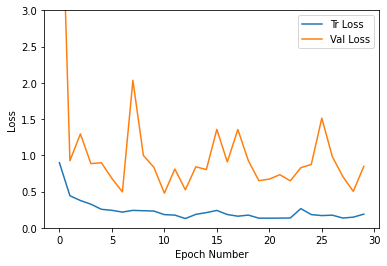

In [16]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

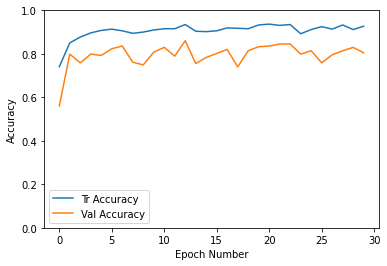

In [17]:
# 6. Analyze the accuracy curve

from matplotlib import pyplot as plt

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

#Q2. Training the dataset after modification of the basic model

In [2]:
#Modify the model used in Q1 (Question 1)
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.fc1 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64, eps = 1e-2)
        self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(64, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1) #the viewing function means flattening for linear
       # and also our new layers. 
        output = self.dp(self.bn1(self.relu(self.fc0(output))))
        output = self.dp(self.bn2(self.relu(self.fc1(output))))
        output = self.classifier(output)
                
        return output
    
model = MyCustomResnet18()

NameError: ignored

In [3]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

NameError: ignored

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer_ft, num_epochs)

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

In [ ]:
# 6. Analyze the accuracy curve

from matplotlib import pyplot as plt

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

# Q3. Training the dataset after data-centric strategies 

The total number of classes are 4 which are pumpkin, durian, tomato and watermelon. The datasets have a few problems such as misplaced dataset, the fruit not being the point of focus and not enough data provided. Modifications need to be made to the dataset such as:

1.Ensuring that all data classes are to fit 150 images

2.Increasing the amount of durian images for the dataset class

3.Removing any fruit images that are in the wrong class


In [18]:
#Change the directory to the new dataset after applying data-centric strategies
%cd /content/gdrive/MyDrive/fruit_dataset_new 

/content/gdrive/.shortcut-targets-by-id/1M_FX2K001rVj6xi9M72zC0wFhTDXYVK1/fruit_dataset_new


In [29]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [30]:
train_directory = os.path.join('train')
test_directory = os.path.join('validation')

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

4


In [31]:
data['train']

Dataset ImageFolder
    Number of datapoints: 400
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [32]:
data['test']

Dataset ImageFolder
    Number of datapoints: 200
    Root location: validation
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [33]:
#######################################################
#                  Create Dataloader                  #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=16, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

400
200


In [34]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'model_'+str(epoch)+'.pt')
            
    return model, history

In [35]:
#Viewing the layer
mnetv2 = models.resnet101(pretrained=True)
mnetv2

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
class MyCustomModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        axnet = models.alexnet(pretrained=pretrained)
        self.features = nn.ModuleList(axnet.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = axnet.classifier[1].in_features

        # resnet18 = models.resnet18(pretrained=pretrained)
        # self.features = nn.ModuleList(resnet18.children())[:-1]
        # self.features = nn.Sequential(*self.features)
        # in_features = resnet18.fc.in_features

        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        # self.fc1 = nn.Linear(256, 64)
        # self.bn2 = nn.BatchNorm1d(64, eps = 1e-2)
        self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.dp(self.bn1(self.relu(self.fc0(output))))
        # output = self.dp(self.bn2(self.relu(self.fc1(output))))
        output = self.classifier(output)
                
        return output
    
model = MyCustomModel()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [37]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

MyCustomModel(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (fc0): Linear(in_features=9216, out_features=256, bias=True)
  (bn1): Batch

In [47]:
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer_ft, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 0.8818, Accuracy: 72.7500%, 
		Validation : Loss : 1.5088, Accuracy: 81.5000%, Time: 122.4859s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.3854, Accuracy: 87.2500%, 
		Validation : Loss : 1.6465, Accuracy: 61.5000%, Time: 4.4152s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.3241, Accuracy: 87.7500%, 
		Validation : Loss : 0.9766, Accuracy: 72.5000%, Time: 4.3608s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.3245, Accuracy: 90.5000%, 
		Validation : Loss : 1.0007, Accuracy: 69.5000%, Time: 4.4411s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.2107, Accuracy: 91.7500%, 
		Validation : Loss : 1.3430, Accuracy: 56.0000%, Time: 4.3836s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.2198, Accuracy: 91.2500%, 
		Validation : Loss : 4.1191, Accuracy: 57.5000%, Time: 4.3838s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.2600, Accuracy: 91.7500%, 
		Validation : Loss : 5.7485, Accuracy: 50.5000%, Time: 4.3523s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.4041, Accuracy: 8

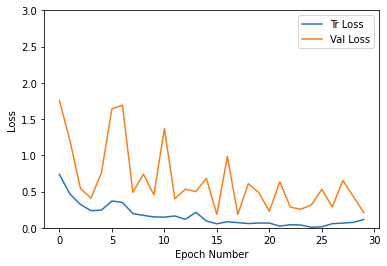

In [ ]:
# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

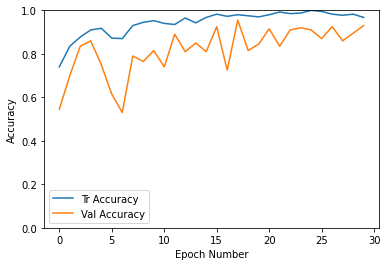

In [ ]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

#Q4. Training the model using three images while providing inferences

In [1]:
#Read the image that will be used to test 
img = cv2.imread("test_durian.jpg")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

NameError: ignored

In [43]:
#model = torch.load("/content/drive/MyDrive/fruit_dataset_new/modelbest.pt")
model.eval()

MyCustomModel(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (fc0): Linear(in_features=9216, out_features=256, bias=True)
  (bn1): Batch

In [44]:
# Carry out inference

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        ])

img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0).to(device)

out = model(batch_t)
print(out.shape)

torch.Size([1, 4])


watermelon 0.9441741704940796
tomato 0.04884900152683258
durian 0.006684842053800821
pumpkin 0.0002919738180935383


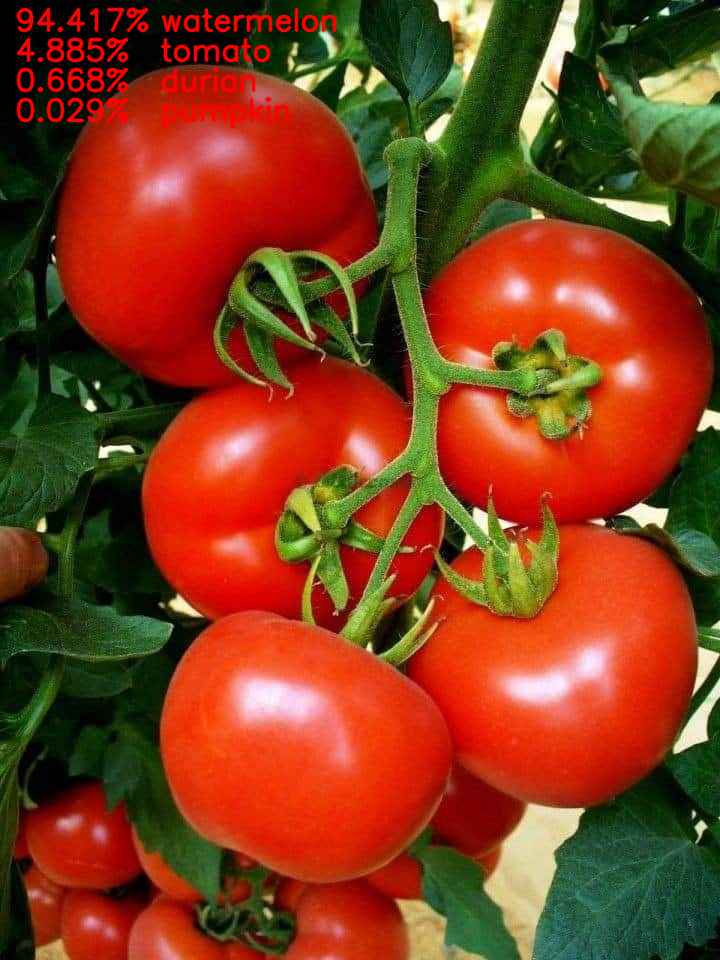

In [45]:
from google.colab.patches import cv2_imshow

classes = ['durian', 'pumpkin', 'tomato', 'watermelon']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 4)

for i in range(top5_prob.size(0)):
    cv2.putText(img, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()